# IGRINS T-dwarf spectrum from Tannock et al. 2022

Can `blase` work on high resolution spectra of ultracool dwarfs?  Let's find out!  We will infer imperfections in the Sonora template using transfer learning.  The data will come from [Tannock et al. 2022](https://ui.adsabs.harvard.edu/abs/2022MNRAS.tmp.1421T/abstract), which presents a high signal-to-noise ratio spectrum of the cloud-free T6 [2MASS J08173001-6155158](http://simbad.cds.unistra.fr/simbad/sim-basic?Ident=2MASS+J08173001-6155158&submit=SIMBAD+search).

In [1]:
%config Completer.use_jedi = False

In [2]:
import torch
from blase.emulator import SparseLogEmulator, ExtrinsicModel, InstrumentalModel
import matplotlib.pyplot as plt
from gollum.phoenix import PHOENIXSpectrum
from gollum.telluric import TelFitSpectrum
from blase.utils import doppler_grid
from astropy.nddata import StdDevUncertainty
import pandas as pd
import astropy.units as u
import numpy as np

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
device

'cuda'

## Fetch and transform the data

The data availability statement in the paper shows how to retrieve the data:

> The raw IGRINS data for 2MASS J08173001−6155158 are available on the Gemini Archive under Program ID GS-2018A-Q-304.
The reduced spectrum and best-fitting Bobcat Alternative A spectra
are available through the Harvard Dataverse (https://doi.org/10.7910/DVN/DV1ZLR) or Zenodo (https://doi.org/10.5281/zenodo.6082001).

In [4]:
from muler.igrins import IGRINSSpectrum

In [5]:
#! mv /home/gully/Downloads/2MASS081730011-155158_IGRINS_full_K_band_orders_stitched.txt ../../data/
#! mv /home/gully/Downloads/2MASS081730011-155158_IGRINS_full_H_band_orders_stitched.txt ../../data/
#! head -n 20 ../../data/2MASS081730011-155158_IGRINS_full_K_band_orders_stitched.txt

In [7]:
names = ['wavelength_um','flux','uncert','snr']

In [14]:
df = pd.read_csv('../../data/2MASS081730011-155158_IGRINS_full_K_band_orders_stitched.txt', 
            comment='#', names=names)

df = df.dropna().reset_index(drop=True)

In [15]:
uncertainty = StdDevUncertainty(df.uncert.values)

In [16]:
data_K = IGRINSSpectrum(spectral_axis=df.wavelength_um.values*10_000*u.Angstrom,
                     flux=df.flux.values*u.dimensionless_unscaled, 
                     uncertainty=uncertainty)

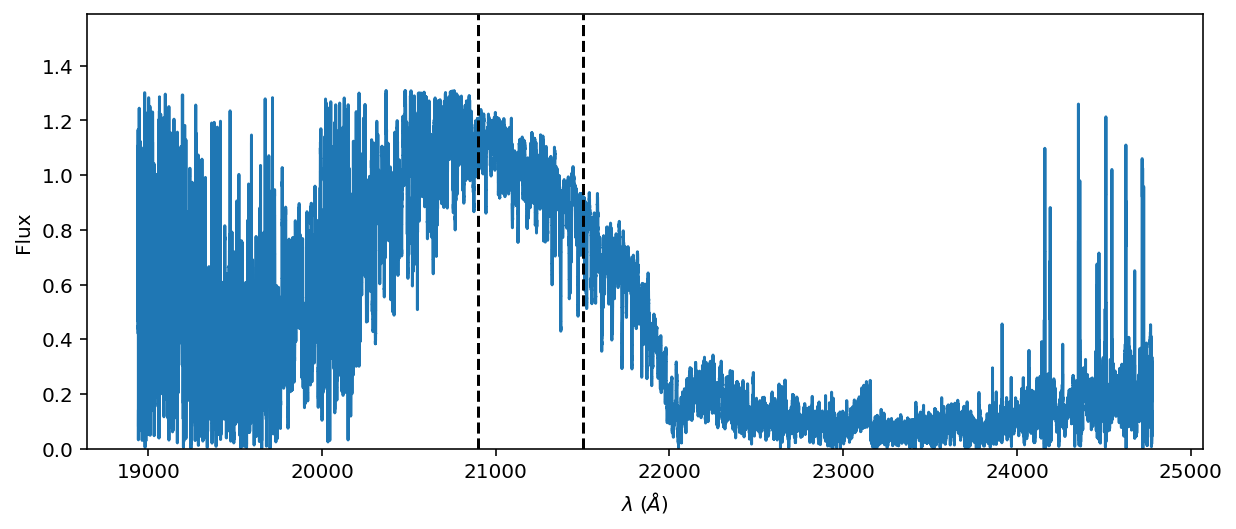

In [17]:
ax = data_K.plot()
ax.axvline(21500, linestyle='dashed', color='k')
ax.axvline(20900, linestyle='dashed', color='k')

Neat! Let's trim the data to a small sub-region for now.

In [11]:
mask = (data_K.wavelength.value < 21500) & (data_K.wavelength.value>20900)

In [12]:
data = data_K.apply_boolean_mask(mask)

Let's flatten the spectrum:

In [13]:
data = data.normalize(normalize_by='peak')
#flatten(window_length=1401,sigma=3, polyorder=2).normalize(normalize_by='peak')
                

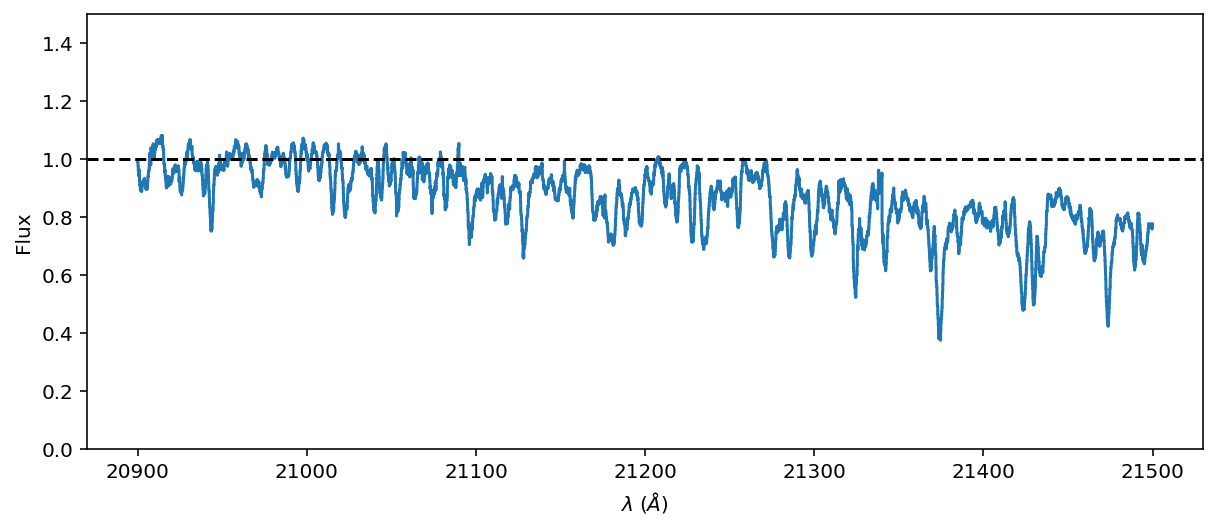

In [14]:
ax = data.plot();
ax.axhline(1.0, linestyle='dashed', color='k');

In [15]:
wl_lo = data.wavelength.value.min()-30.0
wl_hi = data.wavelength.value.max()+30.0
wavelength_grid = doppler_grid(wl_lo, wl_hi)

### Retrieve the Phoenix model

In [16]:
from gollum.sonora import SonoraGrid, SonoraSpectrum

In [17]:
grid = SonoraGrid(teff_range=(800, 1300), logg_range=(3, 5.5), metallicity_range=(-0.5, 0.5),
                   wl_lo=wl_lo, wl_hi=wl_hi, path='~/libraries/raw/SonoraBobcat2021/')

Processing Teff=1300 K, logg=5.50, metallicity=0.5: 100%|████████| 8/8 [00:21<00:00,  2.74s/it]


Find the best fit template with the [interactive dashboard](https://gollum-astro.readthedocs.io/en/latest/tutorials/Phoenix_dashboard_demo.html).

The javascript dashboard cannot be shown easily only due to a Python backend server connection.  Try it for yourself by installing [gollum](https://gollum-astro.readthedocs.io/en/latest/install.html).

In [18]:
grid.show_dashboard(data=data)

From the interactive dashboard, we find:

| Property| IGRINS by-eye fit| Tannock et al. 2022 |
| -- | -- | -- |
|$T_{\mathrm{eff}}$| -- K| -- K|
|$\log{g}$| --| -- |
|Metallicty| --| -- |
|$v\sin{i}$| -- km/s|  -- km/s|
|$v_z$|-- km/s| $\cdots$ |
|RV|-- km/s| -- km/s|


## PAUSE

In [19]:
system_RV = 6.1 #km/s
observed_RV = 25.4 # system_RV - BERV (km/s)
vsini = 22.5 #km/s
resolving_power = 45_000

In [20]:
native_spectrum = SonoraSpectrum(teff=1000, logg=5.5, metallicity=0.0, wl_lo=wl_lo, wl_hi=wl_hi)
native_spectrum = native_spectrum.normalize()
native_spectrum = native_spectrum.divide(np.percentile(native_spectrum.flux, 95))
continuum_fit = native_spectrum.fit_continuum(polyorder=5)
#native_spectrum = native_spectrum.divide(continuum_fit, handle_meta="ff")
spectrum = native_spectrum.rotationally_broaden(vsini)
spectrum = spectrum.rv_shift(observed_RV)
spectrum = spectrum.instrumental_broaden(resolving_power=resolving_power)

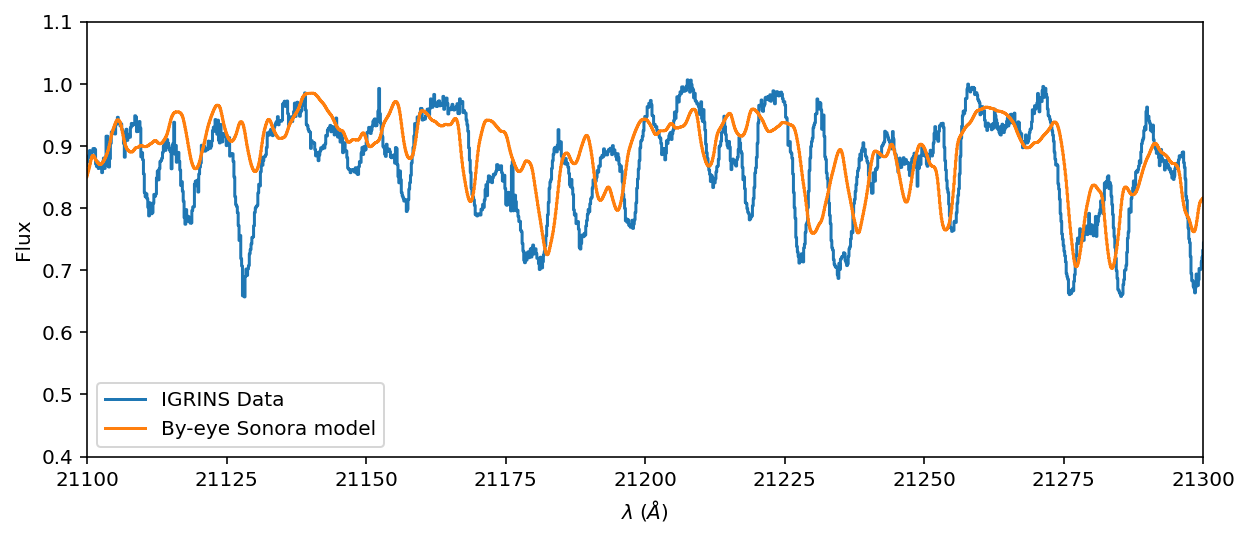

In [21]:
ax = data.plot(yhi=1.1, ylo=0.4, label='IGRINS Data')
spectrum.plot(ax=ax, label='By-eye Sonora model')
ax.legend();ax.set_xlim(21100, 21300); 

Hmmm... not a great fit!  We need to warp out low-order polynomials...

In [22]:
initial_guess = spectrum.resample(data)

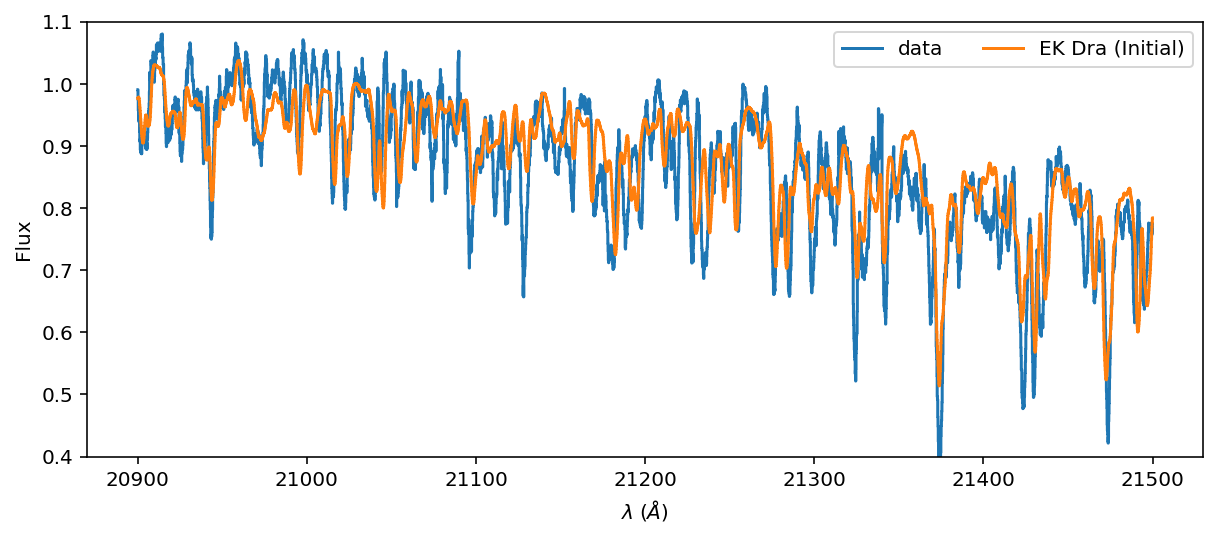

In [23]:
ax = data.plot(label='data', yhi=1.1, ylo=0.4)
initial_guess.plot(ax=ax, label='EK Dra (Initial)')
ax.legend(ncol=3);

There are some conspicuous data model mismatches.

### Clone the stellar and telluric model

In [24]:
stellar_emulator = SparseLogEmulator(native_spectrum.wavelength.value, 
                                     np.log(native_spectrum.flux.value), prominence=0.01, device=device)
stellar_emulator.to(device)

/home/gully/GitHub/blase/src/blase/emulator.py:360: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.target = torch.tensor(


Initializing a sparse model with 515 spectral lines


SparseLogEmulator()

### Fine-tune the clone

In [25]:
stellar_emulator.optimize(epochs=1000, LR=0.01)

Training Loss: 0.00016694: 100%|██████████████████████████| 1000/1000 [00:05<00:00, 186.88it/s]


In [26]:
with torch.no_grad():
    clone_flux = stellar_emulator.forward().detach().cpu().numpy()

(21200.0, 21300.0)

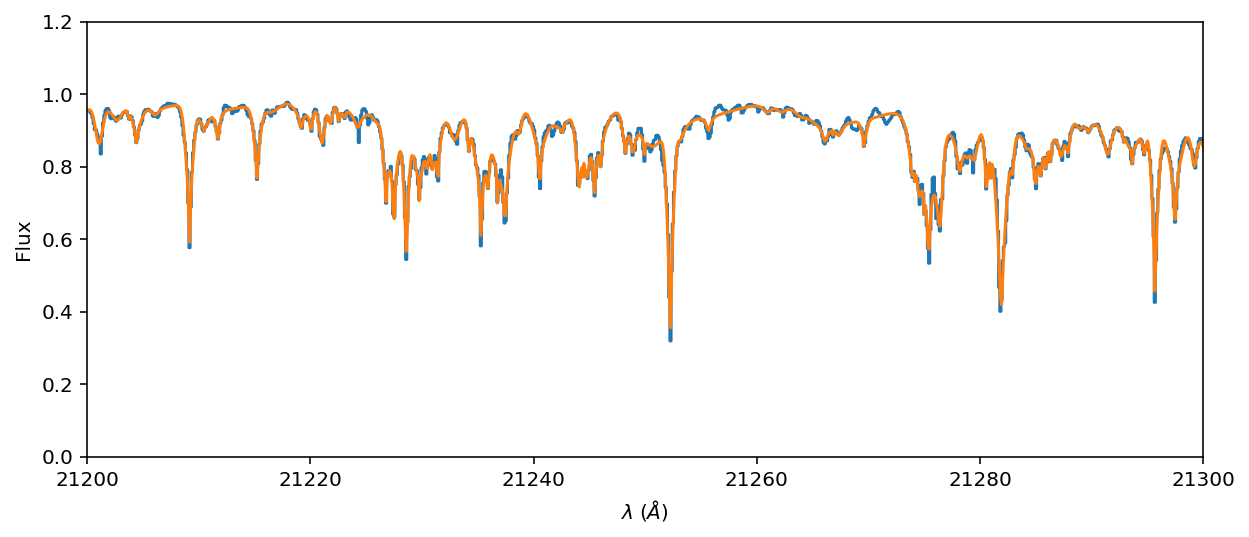

In [27]:
ax = native_spectrum.plot(ylo=0)
ax.plot(native_spectrum.wavelength.value, clone_flux)
ax.set_xlim(21200, 21300)

### Step 3: Extrinsic model

In [28]:
extrinsic_layer = ExtrinsicModel(wavelength_grid, device=device)
vsini = torch.tensor(vsini)
extrinsic_layer.ln_vsini.data = torch.log(vsini)
extrinsic_layer.to(device)

ExtrinsicModel()

(Remap the stellar and telluric emulator to a standardized wavelength grid).

In [29]:
stellar_emulator = SparseLogEmulator(wavelength_grid, 
                                     init_state_dict=stellar_emulator.state_dict(), device=device)
stellar_emulator.radial_velocity.data = torch.tensor(observed_RV)
stellar_emulator.to(device)

Initializing a sparse model with 515 spectral lines


SparseLogEmulator()

#### Forward model

In [30]:
stellar_flux = stellar_emulator.forward()
broadened_flux = extrinsic_layer(stellar_flux)

#### Joint telluric and stellar model

In [31]:
flux_at_telescope = broadened_flux

#### Instrumental model

In [32]:
instrumental_model = InstrumentalModel(data.bin_edges.value, wavelength_grid, device=device)
instrumental_model.to(device)

InstrumentalModel(
  (linear_model): Linear(in_features=15, out_features=1, bias=True)
)

In [33]:
instrumental_model.ln_sigma_angs.data = torch.log(torch.tensor(0.063))

In [34]:
detector_flux = instrumental_model.forward(flux_at_telescope)

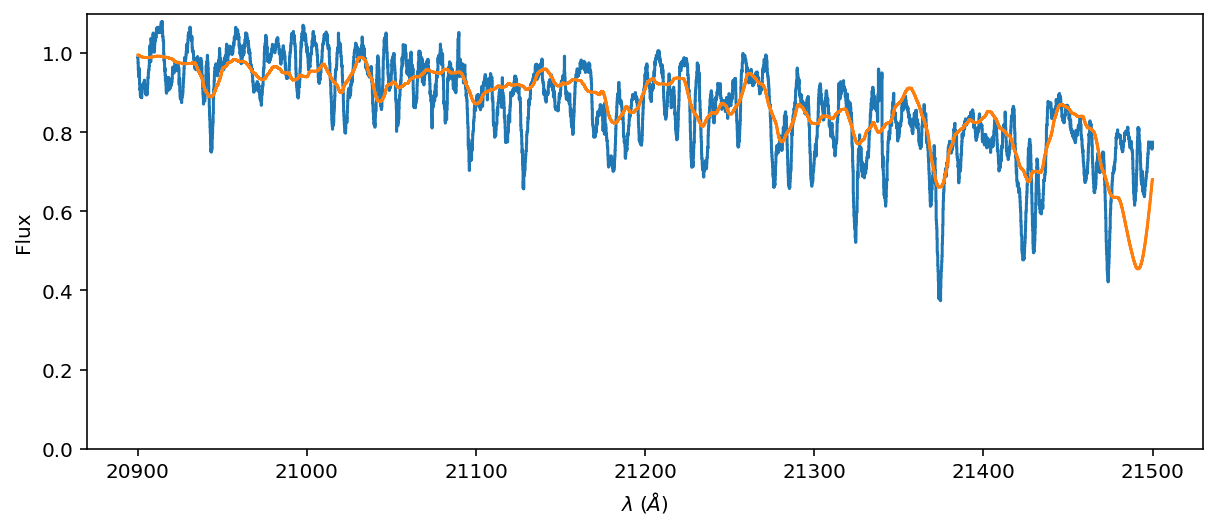

In [35]:
ax = data.plot(yhi=1.1)
ax.step(data.wavelength, detector_flux.detach().cpu().numpy());

## Transfer learn a semi-empirical model

In [36]:
from torch import nn
from tqdm import trange
import torch.optim as optim

In [37]:
data_target = torch.tensor(
    data.flux.value.astype(np.float64), device=device, dtype=torch.float64
)

data_wavelength = torch.tensor(
    data.wavelength.value.astype(np.float64), device=device, dtype=torch.float64
)

In [38]:
loss_fn = nn.MSELoss(reduction="mean")

### Fix certain parameters, allow others to vary
As we have seen before, you can fix parameters by "turning off their gradients".  We will start by turning off *ALL* gradients.  Then turn on some.

In [39]:
for key in stellar_emulator.state_dict().keys():
    stellar_emulator.__getattr__(key).requires_grad = False

In [40]:
stellar_emulator.amplitudes.requires_grad = True
stellar_emulator.lam_centers.requires_grad = True
stellar_emulator.radial_velocity.requires_grad = True
extrinsic_layer.ln_vsini.requires_grad = True
instrumental_model.ln_sigma_angs.requires_grad = True

In [51]:
optimizer = optim.Adam(
    list(filter(lambda p: p.requires_grad, stellar_emulator.parameters()))
    + list(filter(lambda p: p.requires_grad, extrinsic_layer.parameters()))
    + list(filter(lambda p: p.requires_grad, instrumental_model.parameters())),
    0.01,
    amsgrad=True,
)         

In [52]:
n_epochs = 2000
losses = []

## Regularization is fundamental

The blase model as it stands is **too flexible**.  It must have regularization to balance its propensity to overfit.

First, we need to assign uncertainty to the data in order to weigh the prior against new data:

In [53]:
# We need uncertainty to be able to compute the posterior
# Assert fixed per-pixel uncertainty for now
per_pixel_uncertainty = torch.tensor(0.005, device=device, dtype=torch.float64)

Then we need the prior.  For now, let's just apply priors on the amplitudes (almost everything else is fixed).  We need to set the regularization hyperparameter tuning.

In [54]:
stellar_amp_regularization = 0.15
stellar_lam_regularization = 0.5

In [55]:
import copy

In [56]:
with torch.no_grad():
    stellar_init_amps = copy.deepcopy(torch.exp(stellar_emulator.amplitudes))
    stellar_init_lams = copy.deepcopy(stellar_emulator.lam_centers)

# Define the prior on the amplitude
def ln_prior(stellar_amps, lam_centers):
    """
    Prior for the amplitude vector
    """
    amp_diff1 = stellar_init_amps - torch.exp(stellar_amps)
    ln_prior1 = 0.5 * torch.sum((amp_diff1 ** 2) / (stellar_amp_regularization ** 2))
    
    lam_diff1 = stellar_init_lams - lam_centers
    ln_prior3 = 0.5 * torch.sum((lam_diff1 ** 2) / (stellar_lam_regularization ** 2))

    return ln_prior1 + ln_prior3

In [57]:
t_iter = trange(n_epochs, desc="Training", leave=True)
for epoch in t_iter:
    stellar_emulator.train()
    extrinsic_layer.train()
    instrumental_model.train()
    
    stellar_flux = stellar_emulator.forward()
    broadened_flux = extrinsic_layer(stellar_flux)
    flux_at_telescope = broadened_flux
    detector_flux = instrumental_model.forward(flux_at_telescope)
    
    loss = loss_fn(detector_flux / per_pixel_uncertainty, data_target / per_pixel_uncertainty)
    #loss += ln_prior(stellar_emulator.amplitudes, 
    #                 stellar_emulator.lam_centers)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    t_iter.set_description("Training Loss: {:0.8f}".format(loss.item()))

Training Loss: 4.42674829: 100%|███████████████████████████| 2000/2000 [04:36<00:00,  7.24it/s]


### Spot check the transfer-learned joint model

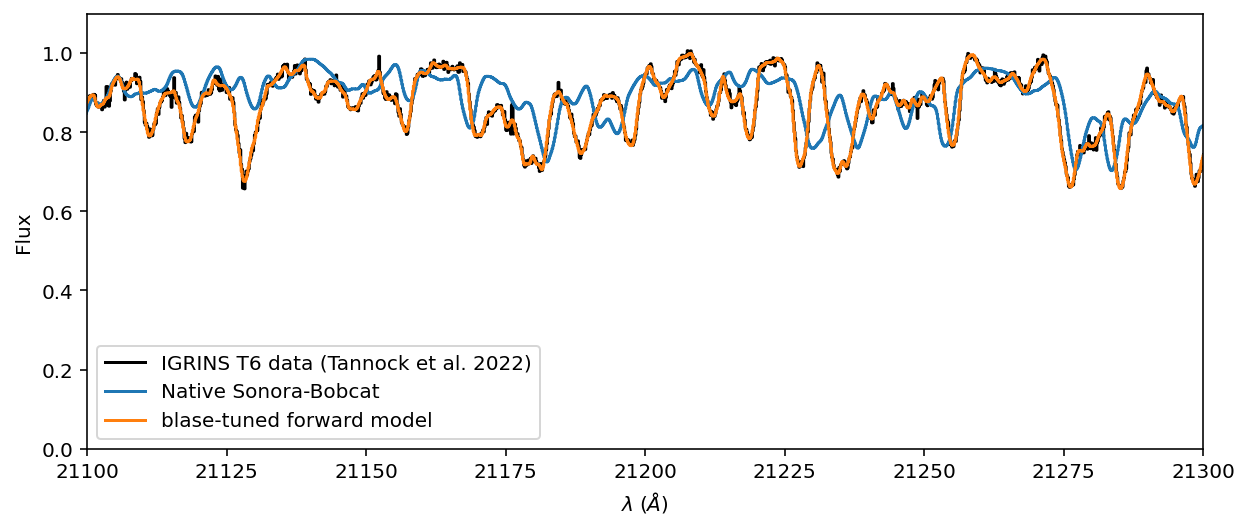

In [61]:
ax = data.plot(yhi=1.1, label='IGRINS T6 data (Tannock et al. 2022)', color='k')
ax.step(data.wavelength, initial_guess.flux.value,
       label='Native Sonora-Bobcat');
ax.step(data.wavelength, instrumental_model.forward(broadened_flux).detach().cpu().numpy(),
       label='blase-tuned forward model');
ax.set_xlim(21100, 21300)
ax.legend();

Hmm, something seems off, it should be better than this!

### Inspect the individual stellar and telluric components

In [59]:
with torch.no_grad():
    stellar_emulator.radial_velocity.data *=0
    stellar_post = stellar_emulator.forward().cpu().numpy()

(21100.0, 21200.0)

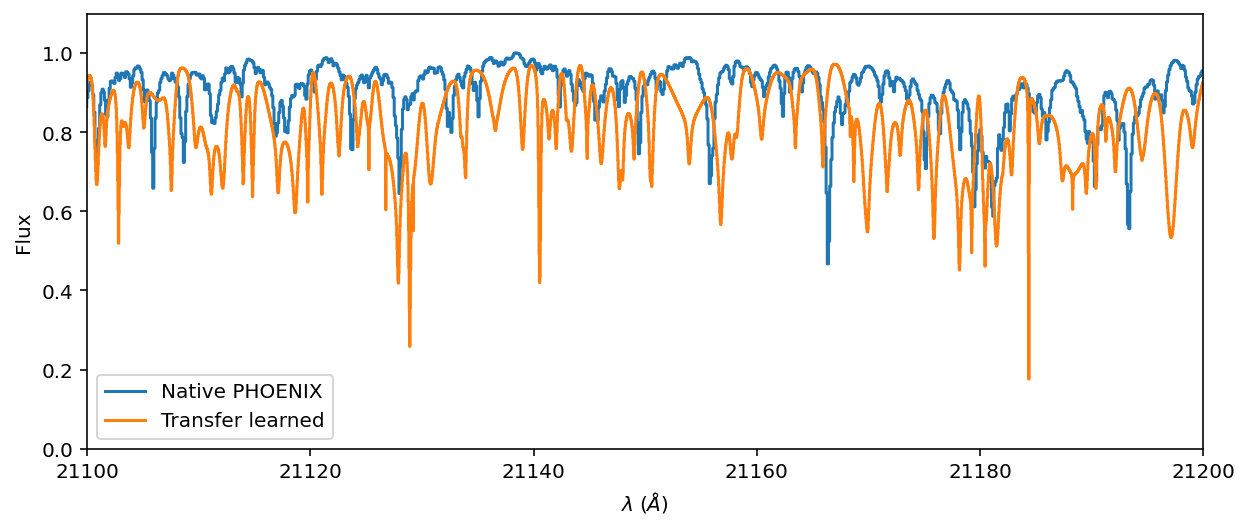

In [63]:
ax = native_spectrum.plot(ylo=0, yhi=1.1, label='Native PHOENIX')
ax.step(wavelength_grid, stellar_post, label='Transfer learned');
ax.legend()
ax.set_xlim(21100, 21200)

Neat, it looks like we are refining the model at its native resolution. 